Kullanılan cihaz: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]


Eğitim başlıyor...
Epoch [1/10], Loss: 0.0342
Epoch [2/10], Loss: 0.0233
Epoch [3/10], Loss: 0.0202
Epoch [4/10], Loss: 0.0187
Epoch [5/10], Loss: 0.0176
Epoch [6/10], Loss: 0.0135
Epoch [7/10], Loss: 0.0129
Epoch [8/10], Loss: 0.0136
Epoch [9/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0110


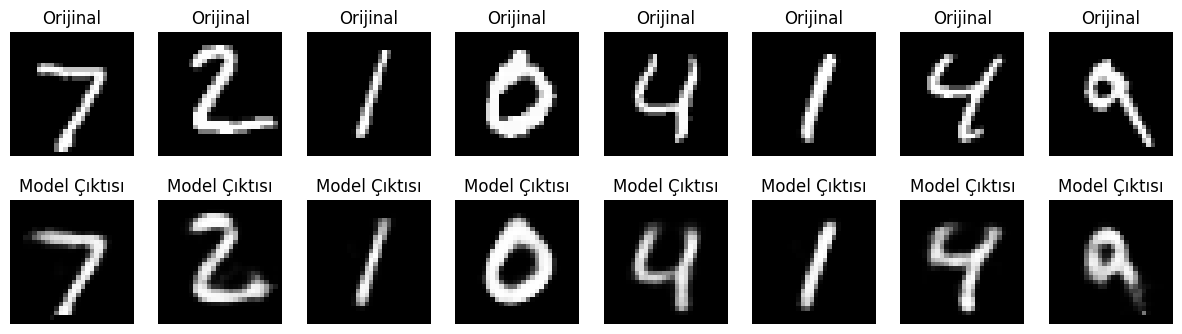

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- 1. Ayarlar ve Cihaz Seçimi ---
# Eğitimin hızlı olması için GPU varsa onu seçiyoruz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Hiperparametreler
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
LATENT_DIM = 32  # 784 piksellik görüntüyü 32 sayıya sıkıştıracağız!

# --- 2. Veri Setini Hazırlama ---
# Görüntüleri Tensöre çevirir (0-1 aralığına getirir)
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. Otomatik Kodlayıcı (Autoencoder) Modeli ---
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # --- ENCODER (Kodlayıcı) ---
        # Girdi: 28x28 = 784 piksel
        # Amaç: Boyutu azaltmak (Sıkıştırma)
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # 784 -> 128
            nn.ReLU(),
            nn.Linear(128, 64),      # 128 -> 64
            nn.ReLU(),
            nn.Linear(64, LATENT_DIM), # 64 -> 32 (Darboğaz / Latent Space)
            nn.ReLU()
        )
        
        # --- DECODER (Kod Çözücü) ---
        # Girdi: Latent Space (32)
        # Amaç: Orijinal boyuta geri dönmek (Yeniden Yapılandırma)
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 64), # 32 -> 64
            nn.ReLU(),
            nn.Linear(64, 128),        # 64 -> 128
            nn.ReLU(),
            nn.Linear(128, 28 * 28),   # 128 -> 784
            nn.Sigmoid() # Çıktıyı [0, 1] aralığına sıkıştırmak için (Pikseller gibi)
        )

    def forward(self, x):
        # Görüntüyü düzleştir (Batch_Size, 784)
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Çıktıyı tekrar görüntü formatına sok (Batch_Size, 1, 28, 28)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

# Modeli başlat
model = Autoencoder().to(device)
criterion = nn.MSELoss() # Mean Squared Error (Girdi ile Çıktı arasındaki fark)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Eğitim Döngüsü ---
print("Eğitim başlıyor...")
for epoch in range(NUM_EPOCHS):
    for data in train_loader:
        img, _ = data # Etiketlere (labels) ihtiyacımız yok, "_" ile atlıyoruz
        img = img.to(device)
        
        # Forward
        output = model(img)
        
        # Loss Hesaplama
        # DİKKAT: Hedefimiz (target) girdinin kendisi (img)!
        loss = criterion(output, img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

# --- 5. Sonuçları Görselleştirme ---
# Test setinden bir batch alıp sonuçlara bakalım
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    reconstructed = model(images) # Modelden geçir

    # CPU'ya al ve görselleştir
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # İlk 8 görüntüyü çiz
    n = 8
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Orijinal Görüntüler (Üst Satır)
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title("Orijinal")
        plt.axis('off')

        # Yeniden Yapılandırılanlar (Alt Satır)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Model Çıktısı")
        plt.axis('off')
    
    plt.show()

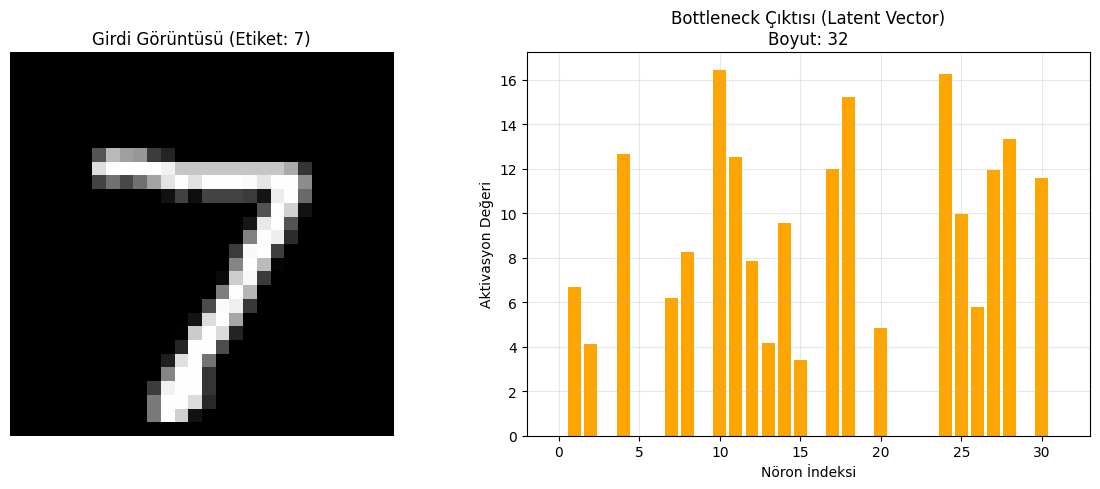

Sıkıştırılmış Vektör Değerleri:
[ 0.         6.6954603  4.1306763  0.        12.675183   0.
  0.         6.169298   8.255659   0.        16.42369   12.536048
  7.833936   4.1890354  9.543335   3.4224112  0.        12.01137
 15.244444   0.         4.8607903  0.         0.         0.
 16.246035   9.982588   5.770379  11.958375  13.322782   0.
 11.605607   0.       ]


In [2]:
# --- Bottleneck (Gizli Katman) Çıktısını Alma ---

# 1. Test setinden örnek bir görüntü alalım
images, labels = next(iter(test_loader))
test_img = images[0]     # Batch'teki ilk görüntü (Boyut: 1, 28, 28)
test_label = labels[0]   # Etiketi (Örn: 7)

# 2. Görüntüyü modele uygun hale getirelim (Flatten ve Device)
# Modelimiz (Batch, 784) beklediği için boyutu düzeltiyoruz
test_img_flatten = test_img.view(-1, 28 * 28).to(device)

# 3. Sadece ENCODER kısmını çalıştıralım
model.eval()
with torch.no_grad():
    # model(x) yerine model.encoder(x) çağırıyoruz!
    bottleneck_output = model.encoder(test_img_flatten)

# --- Sonuçları Görselleştirme ---
bottleneck_vector = bottleneck_output.cpu().numpy().flatten() # Çizim için numpy array'e çevir

plt.figure(figsize=(12, 5))

# Sol Taraf: Orijinal Görüntü
plt.subplot(1, 2, 1)
plt.imshow(test_img.reshape(28, 28), cmap='gray')
plt.title(f"Girdi Görüntüsü (Etiket: {test_label.item()})")
plt.axis('off')

# Sağ Taraf: Bottleneck Çıktısı (32 Boyutlu Vektör)
plt.subplot(1, 2, 2)
plt.bar(range(len(bottleneck_vector)), bottleneck_vector, color='orange')
plt.title(f"Bottleneck Çıktısı (Latent Vector)\nBoyut: {len(bottleneck_vector)}")
plt.xlabel("Nöron İndeksi")
plt.ylabel("Aktivasyon Değeri")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sıkıştırılmış Vektör Değerleri:\n{bottleneck_vector}")

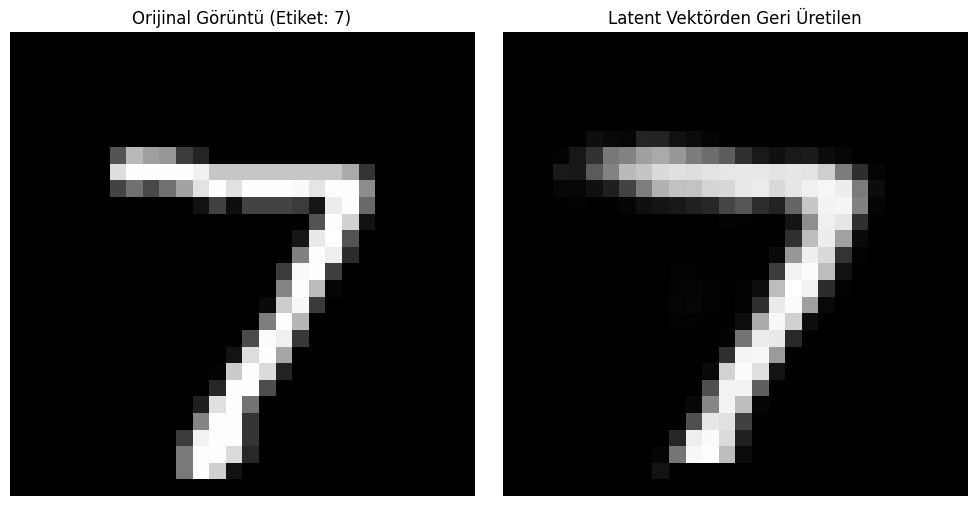

Bir görüntünün bottleneck vektöründen geri üretilmesi başarılı.


In [5]:
# --- Bottleneck Çıktısından Yeni Görüntü Üretme ---

# Önceki adımdan elimizde olanlar:
# bottleneck_output (torch.Tensor, device üzerinde, boyutu: 1, LATENT_DIM)
# test_img (torch.Tensor, cpu üzerinde, boyutu: 1, 28, 28)
# test_label (torch.Tensor, cpu üzerinde, tek bir sayı)

# 1. Bottleneck çıktısından görüntüyü yeniden yapılandırmak için DECODER kullan
model.eval()
with torch.no_grad():
    # model.encoder(x) yerine model.decoder(z) çağırıyoruz!
    reconstructed_from_bottleneck = model.decoder(bottleneck_output)

# CPU'ya al ve görselleştirme için hazırla
reconstructed_from_bottleneck = reconstructed_from_bottleneck.cpu().squeeze() # Squeeze tek kanal boyutunu kaldırır (28, 28)

plt.figure(figsize=(10, 5))

# Sol Taraf: Orijinal Görüntü
plt.subplot(1, 2, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"Orijinal Görüntü (Etiket: {test_label.item()})")
plt.axis('off')

# Sağ Taraf: Bottleneck Çıktısından Yeniden Yapılandırılmış Görüntü
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_from_bottleneck.reshape(28, 28), cmap='gray')
plt.title("Latent Vektörden Geri Üretilen")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Bir görüntünün bottleneck vektöründen geri üretilmesi başarılı.")
